# **Machine Learning for NLP**
### Airouche Yannis, Braulotte Paul




IMDB is a well-known database for movies, including ratings and reviews. Our objective here is to build a language model capable of classifying movies into different categories. First of all, we will build a binary classification model which takes in input a review and predicts whether it is a positive or negative
critic.

### **Database**
First of all, we import the Large Movie Review Dataset from the researchers' website. Then, we extract the tar file in the environment.

In [ ]:
# Importing database
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar

# Extracting database
!tar xzf aclImdb_v1.tar

--2021-04-24 09:38:36--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar’

aclImdb_v1.tar      100%[===================>]  80.23M  25.7MB/s    in 3.5s    

2021-04-24 09:38:40 (23.0 MB/s) - ‘aclImdb_v1.tar’ saved [84125825/84125825]



This dataset is particular. It is composed of many text files which contain the users' reviews. Each file name also contains the rating from the user. We need to structure our database in a csv file, extracting the text review and the rating from the file.

In [ ]:
import os
import pandas as pd
import csv
import re
from tqdm import tqdm

def merge_txt_files(path, files):
  """
  Function creating a pandas dataframe from text files.
  :param path: path to the text files folder.
  :param files: list of the files name.
  :return: pandas dataframe.
  """
  # Creating the dataframe with two columns
  # 'Data' contains the text review and 'ratings' an integer from 1 to 10.
  df = pd.DataFrame(columns=['data', 'ratings'])
  # Loop on files name
  for file in tqdm(files):
    # Temp dataframe to store the content of the txt file
    _df = pd.read_csv(file, quoting=csv.QUOTE_NONE, names=['data'], delimiter = "\t", encoding='latin-1')
    # Name of the file
    s = os.path.split(file)[1]
    # Get the rating of the review from the filename
    _df['ratings'] = int(re.search(r'\_(.*?).txt', s).group(1))
    # Concatenate the review and the rating in the final dataframe
    df = pd.concat([df, _df], ignore_index=True) 
  return df


def converting_database():
  """
  Method returning the training and the test datasets as pandas dataframes.
  """
  ### Train set
  # Negative training set
  path = os.path.join(os.getcwd(),'aclImdb/train/neg')
  files = [os.path.join(path,i) for i in os.listdir(path) if os.path.isfile(os.path.join(path,i))]
  print('\nLoading negative train set...')
  df_train_neg = merge_txt_files(path, files)

  # Positive training set
  path = os.path.join(os.getcwd(),'aclImdb/train/pos')
  files = [os.path.join(path,i) for i in os.listdir(path) if os.path.isfile(os.path.join(path,i))]
  print('\nLoading positive train set...')
  df_train_pos = merge_txt_files(path, files)

  # Merging training set
  train_set = pd.concat([df_train_neg, df_train_pos], ignore_index=True)

  ### Test set
  # Negative test set
  path = os.path.join(os.getcwd(),'aclImdb/test/neg')
  files = [os.path.join(path,i) for i in os.listdir(path) if os.path.isfile(os.path.join(path,i))]
  print('\nLoading negative test set...')
  df_test_neg = merge_txt_files(path, files)

  # Positive test set
  path = os.path.join(os.getcwd(),'aclImdb/test/pos')
  files = [os.path.join(path,i) for i in os.listdir(path) if os.path.isfile(os.path.join(path,i))]
  print('\nLoading positive test set...')
  df_test_pos = merge_txt_files(path, files)

  # Merging test set
  test_set = pd.concat([df_test_neg, df_test_pos], ignore_index=True)  

  return train_set, test_set

# Merging txt files into csv file (one file for each set, train and test)
train_set, test_set = converting_database()

  0%|          | 42/12500 [00:00<00:30, 408.84it/s]


Loading negative train set...


  0%|          | 45/12500 [00:00<00:28, 444.15it/s]


Loading positive train set...


  0%|          | 46/12500 [00:00<00:27, 450.50it/s]


Loading negative test set...


  0%|          | 44/12500 [00:00<00:28, 435.98it/s]


Loading positive test set...


100%|██████████| 12500/12500 [00:33<00:00, 374.23it/s]


In [ ]:
import pandas as pd

train_set.to_csv('train_set.csv')
test_set.to_csv('test_set.csv')
train_set = pd.read_csv('train_set.csv', index_col=[0])
test_set = pd.read_csv('test_set.csv', index_col=[0])

This gives us 2 datasets: the train set and the test set, with both positive and negative reviews.

### **Exploring**

In [ ]:
# Description of the training set
train_set.describe(include='all')

,data,ratings
count,25000,25000.000000
unique,24904,NaN
top,How has this piece of crap stayed on TV this l...,NaN
freq,3,NaN
mean,NaN,5.477720
std,NaN,3.466477
min,NaN,1.000000
25%,NaN,2.000000
50%,NaN,5.500000
75%,NaN,9.000000


In [ ]:
# Description of the test set
test_set.describe(include='all')

,data,ratings
count,25000,25000.000000
unique,24801,NaN
top,Loved today's show!!! It was a variety and not...,NaN
freq,5,NaN
mean,NaN,5.512960
std,NaN,3.490902
min,NaN,1.000000
25%,NaN,2.000000
50%,NaN,5.500000
75%,NaN,9.000000


Some reviews are redundant. We will delete them when preprocessing the data.

In [ ]:
# Shape of the datasets
print("Training set shape:  {0}".format(train_set.shape))
print("Test set shape:  {0}".format(test_set.shape))

Training set shape:  (25000, 2)
Test set shape:  (25000, 2)


Here, we display a positive and a negative review from the train and test datasets.

In [ ]:
# Positive and negative review from the training set
print("Positive review: {0}".format(train_set.loc[train_set.ratings > 8, 'data'].iloc[0]))
print("Negative review: {0}".format(train_set.loc[train_set.ratings < 3, 'data'].iloc[0]))

Positive review: Cat Soup at first seems to be a very random animated film. The best way I've been able to explain it is that it's quite acidic. Though it's not totally random. The story is about Nyatta, a young cat boy and his sister Nyaako. Nyaako is very ill and dies, however, Nyatta sees her soul being taken away by death and is able to retrieve half of it. The story is about their quest to bring Nyaako fully back to life.<br /><br />Though a lot of the content in this movie seems completely random, it is not. Most of it is symbolism for life, death and rebirth. You can also see references from other tales, such as Hansel and Gretal. This strangely cute short film has an interesting story, packed with a deeper meaning than what you see on the surface of the screen.
Negative review: Hi, May be because I am not a Theater major or a sophisticated movie watcher ... I think this movie is "Boring" and "Dumb".<br /><br />I rented this movie because of Charles Bronson and it's title ... bu

In [ ]:
# Positive and negative review from the test set
print("Positive review: {0}".format(test_set.loc[test_set.ratings > 8, 'data'].iloc[0]))
print("Negative review: {0}".format(test_set.loc[test_set.ratings < 3, 'data'].iloc[0]))

Positive review: ..this movie has been done when Hitler ( and Mussolini who is as well in the movie) was at the top and many politics and even the Roman Church used to close eyes about brutality and evil of Nazism. Especially in USA there were many people who had not understood what was really going on in Germany and Europe ( Charles Lindenbergh for example ).It would be as today a big actor would made a parody of Berlusconi or Chirac. Chaplin maybe made a lot of mistakes in his life, but this is really a masterpiece of humanity and IMHO a great demonstration he was a courageous man. The movie is funny and deep, the final speech has a terrible strength and is still updated. I think this movie is one of the best ever done.
Negative review: This adorable dog (called various names during the film) is seemingly loved by the whole town...but he's alone. He is friends with two children (Cindy and Paul played astonishingly bad) but their father won't let them have a dog. Then Benji meets Tiff

We can plot the histogram for the ratings to see if the train and test set have similar ratings distribution.

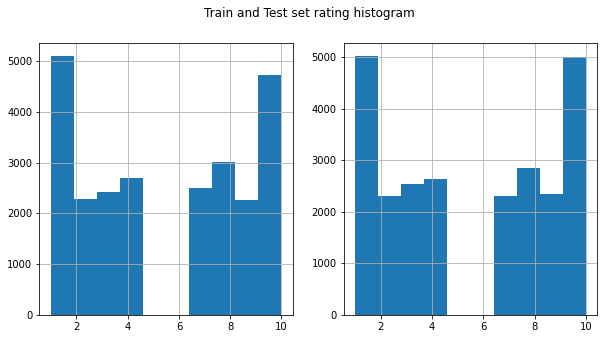

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import pylab as pl

# Train and test set ratings histograms
f, ax = plt.subplots(2,2,figsize=(10,5))
plt.subplot(1, 2, 1)
train_set.ratings.hist()
plt.subplot(1, 2, 2)
test_set.ratings.hist()
pl.suptitle("Train and Test set rating histogram")
plt.show()

Computing the frequencies for each grade confirms that the ratings seems to be similar for the train and test set.

In [ ]:
# Frequencies of ratings in train set
train_set.groupby('ratings').count() / train_set.shape[0]

,data
ratings,
1,0.20400
2,0.09136
3,0.09680
4,0.10784
7,0.09984
8,0.12036
9,0.09052
10,0.18928


In [ ]:
# Frequencies of ratings in test set
test_set.groupby('ratings').count() / test_set.shape[0]

,data
ratings,
1,0.20088
2,0.09208
3,0.10164
4,0.10540
7,0.09228
8,0.11400
9,0.09376
10,0.19996


### **Cleaning Data**
We will remove noisy elements from the text reviews, such as HTML tags and redundant reviews.

In [ ]:
# Cleaning data (removing noisy elements)
import re
import string
# Removing html tag
def remove_html(text):
  cleaned_text = re.sub('<[^<]+?>', '', text)
  return cleaned_text.lower()

def remove_punctuation(text):
    for c in string.punctuation:
      text=text.replace(c," ")
    return text

def remove_multiple_spaces(text):
  return re.sub(' +', ' ', text)

# Dropping dupplicates, removing HTML tag
def clean_data(df):
  clean_df = df.drop_duplicates().copy()
  clean_df.data = clean_df.data.apply(lambda text: remove_html(text))
  clean_df.data=clean_df.data.apply(remove_punctuation)
  clean_df.data=clean_df.data.apply(remove_multiple_spaces)
  return clean_df


# Cleaning train dataset
clean_train_set = clean_data(train_set)
# Cleaning test dataset
clean_test_set = clean_data(test_set)

#print(clean_train_set.data[0])
#print(remove_punctuation(clean_train_set.data[0]))
#print(remove_multiple_spaces(remove_punctuation(clean_train_set.data[0])))

The HTML tag is effectively removed as we can observe below:

In [ ]:
train_set.data.iloc[2]

"'I'm working for a sinister corporation doing industrial espionage in the future and I'm starting to get confused about who I really am, sh*#t! I've got a headache and things are going wobbly, oh no here comes another near subliminal fast-cut noisy montage of significant yet cryptic images...'<br /><br />I rented this movie because the few reviews out there have all been favourable. Why? Cypher is a cheap, derivative, dull movie, set in a poorly realised bland futureworld, with wooden leads, and a laughable ending.<br /><br />An eerie sense that something interesting might be about to happen keeps you watching a series of increasingly silly and unconvincing events, before the film makers slap you in the face with an ending that combines the worst of Bond with a Duran Duran video.<br /><br />It's painfully obvious they have eked out the production using Dr Who style improvised special effects in order to include a few good (if a little Babylon 5) CGI set pieces. This sub Fight Club, su

In [ ]:
clean_train_set.data.iloc[2]

' i m working for a sinister corporation doing industrial espionage in the future and i m starting to get confused about who i really am sh t i ve got a headache and things are going wobbly oh no here comes another near subliminal fast cut noisy montage of significant yet cryptic images i rented this movie because the few reviews out there have all been favourable why cypher is a cheap derivative dull movie set in a poorly realised bland futureworld with wooden leads and a laughable ending an eerie sense that something interesting might be about to happen keeps you watching a series of increasingly silly and unconvincing events before the film makers slap you in the face with an ending that combines the worst of bond with a duran duran video it s painfully obvious they have eked out the production using dr who style improvised special effects in order to include a few good if a little babylon 5 cgi set pieces this sub fight club sub philip k dick future noir thriller strives for a much

### **Positive & Negative Dataset**
We need to create a new column in our datasets, named "sentiment", which will label reviews with either a 1 (for positive review) or a 0 (for negative review).

In [ ]:
def sentiment(df):
  """
  Returns 1 (positive) if ratings is > 5, else 0 (review is negative)
  """
  if df.ratings > 5 :
    return 1
  else:
    return 0

def apply_sentiment(df):
  """
  Creates additional columns to store the review sentiment.
  """
  df["sentiment"] = df.apply(sentiment, axis=1)
  return df

# Adding sentiment column
clean_train_set = apply_sentiment(clean_train_set)
clean_test_set = apply_sentiment(clean_test_set)

**Review Length VS Sentiment**

We check if there is a dependance structure between the length of the review and the sentiment of the user.

In [ ]:
import seaborn as sns
lens=clean_train_set.data.apply(lambda x: len(x.split(' ')))
sen=clean_train_set.sentiment
rat=clean_train_set.ratings
sns.jointplot(data=pd.DataFrame([lens,rat]).T,x='data',y='ratings')

### **BERT**
We first make sure that all the transformers are installed in the notebook.

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.1MB 18.7MB/s 
     |████████████████████████████████| 901kB 53.5MB/s 
     |████████████████████████████████| 3.3MB 48.1MB/s 


We will use the BertTokenizer from BERT pretrained model on English language. This model is uncased: it does not make a difference between english and English.

In [ ]:
from transformers import BertTokenizer

# Loading pre-trained tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

We can observe an example of how the BertTokenizer tokenizes a review, and what token IDs it associates with each tokens.

In [ ]:
# Visualize tokenization
sample_txt = clean_train_set.data.iloc[0] # Example review
tokens = tokenizer.tokenize(sample_txt) # Tokenization of the review
token_ids = tokenizer.convert_tokens_to_ids(tokens) # Get associated token_ids
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: hi may be because i am not a theater major or a sophisticated movie watcher i think this movie is boring and dumb i rented this movie because of charles bronson and it s title but boy what a waste of time just watching 2 guys sitting in a vault and talking the movie on this dvd was so dark i had hard time watching the darn movie i realize it is a 1968 movie but they are putting it on a dvd then they should do some digital remastering also i was totally surprised to see these high marks on imdb for this movie like i said before i am not as sophisticated as the other folks who commented on this movie earlier 
   Tokens: ['hi', 'may', 'be', 'because', 'i', 'am', 'not', 'a', 'theater', 'major', 'or', 'a', 'sophisticated', 'movie', 'watch', '##er', 'i', 'think', 'this', 'movie', 'is', 'boring', 'and', 'dumb', 'i', 'rented', 'this', 'movie', 'because', 'of', 'charles', 'bro', '##nson', 'and', 'it', 's', 'title', 'but', 'boy', 'what', 'a', 'waste', 'of', 'time', 'just', 'watching',

We can plot the distribution of the number of tokens per review.

100%|██████████| 24905/24905 [02:02<00:00, 203.23it/s]
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


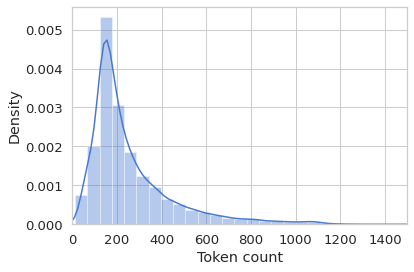

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def tokenize_count_plot(df):
  # List to store the number of tokens per review
  token_lens = []
  # We will run through all training set reviews
  for txt in tqdm(df.data, position=0, leave=True):
    tokens = tokenizer.encode(txt)
    token_lens.append(len(tokens))

  # Plot
  sns.set(style='whitegrid', palette='muted', font_scale=1.2)
  sns.distplot(token_lens)
  plt.xlim([0, 1500]);
  plt.xlabel('Token count');

  return token_lens

token_lens = tokenize_count_plot(clean_train_set)

There is a huge variance in the number of tokens per review. 

In [ ]:
import numpy as np

print(f'Minimum number of tokens for a review: {min(token_lens)}')
print(f'Maximum number of tokens for a review: {max(token_lens)}')
print(f'Mean number of tokens for a review: {np.mean(token_lens)}')

Minimum number of tokens for a review: 12
Maximum number of tokens for a review: 2757
Mean number of tokens for a review: 256.980606303955


Our BERT model will not be able to handle more than 512 inputs. We can visualize how many reviews are exceeding 512 tokens.

In [ ]:
def count_supp(token_lens):
  count = 0
  for tok in token_lens:
    if tok > 512:
      count+=1
  print(f"{round(count/len(token_lens)*100, 2)}% of reviews contain more than 512 tokens.")

count_supp(token_lens)

9.56% of reviews contain more than 512 tokens.


In the following, we create the python class IMDBDataset that we will use to load our datasets.

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from transformers import BertTokenizer, AutoModel
from torch.utils.data import DataLoader

class IMDBDataset(Dataset):
  
  def __init__(self, dataset, max_len, model_name, column_name):
    
    # Dataset
    self.dataset = dataset

    # Sentiment (Binary classififcation)
    # Or Ratings (Multi Class)
    self.column_name = column_name

    # Initialize the BERT tokenizer
    self.tokenizer = BertTokenizer.from_pretrained(model_name)
    self.max_len = max_len
    

  def __len__(self):
    return len(self.dataset)
    

  def __getitem__(self, index):
    
    # Selecting the sentence and label at the specified index in the data frame
    sentence = self.dataset['data'][index]
    label = self.dataset[self.column_name][index]

    # Preprocessing the text to be suitable for BERT
    # Tokenize the sentence
    tokens = self.tokenizer.tokenize(sentence) 
    
    if self.tokenizer.cls_token is None:
      bos_token = self.tokenizer.bos_token
    
    else:
      bos_token = self.tokenizer.cls_token
          
    if self.tokenizer.sep_token is None:
      eos_token = self.tokenizer.eos_token
    
    else:
      eos_token = self.tokenizer.sep_token
        
    # Inserting the CLS and SEP token in the beginning and end of the sentence
    tokens = [bos_token] + tokens + [eos_token] 
    
    if len(tokens) < self.max_len:
      #Padding sentences
      tokens = tokens + [self.tokenizer.pad_token for _ in range(self.max_len - len(tokens))] 
    
    else:
      # Prunning the list to be of specified max length
      tokens = tokens[:self.max_len-1] + [eos_token] 
    
    # Obtaining the indices of the tokens in the BERT Vocabulary
    tokens_ids = self.tokenizer.convert_tokens_to_ids(tokens) 
    # Converting the list to a pytorch tensor
    tokens_ids_tensor = torch.tensor(tokens_ids) 
    # Obtaining the attention mask i.e a tensor containing 1s for no padded tokens and 0s for padded ones
    attn_mask = (tokens_ids_tensor != 0).long()

    return tokens_ids_tensor, attn_mask, label

We define a function that permits to get train, validation and test sets for either the sentiment analysis or the rating prediction.

In [ ]:
from sklearn.model_selection import train_test_split

def get_train_val_test(df_train, df_test, drop_column_name):
  # Shuffle train and test sets
  train_set = df_train.sample(frac=1)
  test_set = df_test.sample(frac=1)

  # Dropping either ratings or sentiment column
  # depending on which model we will train
  train_ = train_set.drop(columns=drop_column_name) 
  val_, test_ = train_test_split(test_set.drop(columns=drop_column_name), test_size=0.5, random_state=42)
  #train_ = train_set.drop(columns=drop_column_name).iloc[:1000]
  #val_, test_ = train_test_split(test_set.drop(columns=drop_column_name).iloc[:1000], test_size=0.5, random_state=42)

  # Reinitializing index
  train_ = train_.reset_index(drop=True)
  val_ = val_.reset_index(drop=True)
  test_ = test_.reset_index(drop=True)
  return train_, val_, test_


# Train, Val, Test sets for sentiment analysis
sent_train, sent_val, sent_test = get_train_val_test(df_train=clean_train_set, 
                                                     df_test=clean_test_set,
                                                     drop_column_name="ratings")

print(sent_train.shape, sent_val.shape, sent_test.shape)

(24905, 2) (12402, 2) (12402, 2)


The following function will handle loading datasets that we will feed to the model.

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

def loading_data(train_, val_, test_, column_name):

  # Setting the maximum length for number of tokens
  max_len = 64

  #Creating instances of training and validation set
  train_set = IMDBDataset(dataset = train_, max_len = max_len, model_name='bert-base-uncased', column_name=column_name)
  val_set = IMDBDataset(dataset = val_, max_len = max_len, model_name='bert-base-uncased', column_name=column_name)
  test_set = IMDBDataset(dataset = test_, max_len = max_len, model_name='bert-base-uncased', column_name=column_name)

  #Creating intsances of training, validation, test dataloaders
  train_loader = DataLoader(train_set, # The training samples
                            sampler = RandomSampler(train_set), # Select batches randomly
                            batch_size = 32, # Trains with this batch size
                            num_workers = 2 # Set number of workers
                            )

  val_loader = DataLoader(val_set, # The validation samples
                          sampler = SequentialSampler(val_set), # Pull out batches sequentially
                          batch_size = 32, # Evaluate with this batch size
                          num_workers = 2 # Set number of workers
                          )

  test_loader = DataLoader(test_set, # The test samples
                            sampler = RandomSampler(test_set), # Select batches randomly
                            batch_size = 32, # Tests with this batch size
                            num_workers = 2 # Set number of workers
                            )
  
  return train_loader, val_loader, test_loader


# Loading datasets for the sentiment analysis
train_loader, val_loader, test_loader = loading_data(train_=sent_train,
                                                     val_=sent_val,
                                                     test_=sent_test,
                                                     column_name="sentiment")

### **Sentiment Analysis model using pytorch**
We define our model using the pytorch library.

In [ ]:
from transformers import AutoModel

class SentimentClassifier(nn.Module):

    def __init__(self, pretrained_model_name='bert-base-uncased'):
        super(SentimentClassifier, self).__init__()
        #Loading Mask Language Model 
        self.encoder = AutoModel.from_pretrained(pretrained_model_name)
        #we append an extra layer for Classification (it will be randomly initialized)
        self.cls_layer = nn.Linear(self.encoder.pooler.dense.out_features, 1)

    def forward(self, seq, attn_masks):
        '''
        Inputs:
            -seq : Tensor of shape [B, T] containing token ids of sequences
            -attn_masks : Tensor of shape [B, T] containing attention masks to be used to avoid contibution of PAD tokens
        '''
        #Feeding the input to BERT model to obtain contextualized representations
        # see in the hugging face doc what to input
        #cont_reps = #  self.encoder(..)..
        cont_reps = self.encoder(seq, attention_mask = attn_masks)
        #Obtaining the representation of [CLS] head
        pool = cont_reps["pooler_output"]
        #Feeding cls_rep to the classifier layer
        logits = self.cls_layer(pool)

        return logits

We then load ou model and will use the gpu to accelerate the training process.

In [ ]:
# Defining the model
sentiment_model = SentimentClassifier('bert-base-uncased')
# Using GPU
sentiment_model = sentiment_model.to("cuda")
# Check if the weights of the model are in gpu : 
sentiment_model.cls_layer.weight.is_cuda

True

### **Training Process**
Here, we will proceed to the training of our model, before testing it on the test dataset.

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import torch.optim as optim
# define the loss and optimizer 
criterion = nn.BCEWithLogitsLoss()
opti = optim.Adam(sentiment_model.parameters(), lr = 1e-4)

In [ ]:
import pdb
import time 

def train(model, criterion, opti, train_loader, val_loader, max_eps=1, gpu=False, print_every=1, validate_every=1, break_training_after=None):
  # We'll store a number of quantities such as training and validation loss, 
  # validation accuracy, and timings.
  training_stats = []

  # Measure the total training time for the whole run.
  total_t0 = time.time()
  
  for ep in range(max_eps):
    # Measure how long the training epoch takes.
    t0 = time.time()
    # time
    duration = time.time()
    # Reset the total loss for this epoch.
    total_train_loss = 0
    total_eval_loss = 0
    # Train mode
    model.train()
    
    for it, (seq, attn_masks, labels) in enumerate(train_loader):
      #Clear gradients
      opti.zero_grad()  
      #Converting these to cuda tensors
      if gpu:
        seq, attn_masks, labels = seq.cuda(), attn_masks.cuda(), labels.cuda()
      #Obtaining the logits from the model
      logits = model(seq, attn_masks)
      #Computing loss
      loss = criterion(logits.squeeze(-1), labels.float())
      # Accumulate loss
      total_train_loss += loss.item()
      #Backpropagating the gradients
      loss.backward()
      #Optimization step
      opti.step()
      
      if (it + 1) % print_every == 0:
        accuracy = torch.sum((logits>0).int().squeeze(1)==labels)/float(labels.size(0))
        print("Iteration {} of epoch {} complete. Loss : {}, Accuracy {}, Exec_time {}s".format(it+1, ep+1, loss.item(),accuracy, round(time.time() - duration, 2)))
        duration = time.time()
      if break_training_after is not None and it>break_training_after:
        print("Early breaking : did not cover a full epoch but only {} iteration ".format(it))
        break
    
    if ep % validate_every==0:
      # Validation mode
      model.eval()
      # evaluation on the validation set 
      n_batch_validation = 0
      loss_validation = 0
      accuracy_validation = 0
      for it, (seq, attn_masks, labels) in enumerate(val_loader):    
        if gpu:
          seq, attn_masks, labels = seq.cuda(), attn_masks.cuda(), labels.cuda()        
        #Obtaining the logits from the model
        logits_val = model(seq, attn_masks)
        n_batch_validation+=1
        #Computing loss
        _loss = float(criterion(logits_val.squeeze(-1), labels.float()))
        _accu = float(torch.sum((logits_val>0).int().squeeze(1)==labels)/float(labels.size(0)))
        loss_validation += _loss
        accuracy_validation += _accu
        # Accumulate the validation loss.
        total_eval_loss += _loss
      print("EVALUATION Validation set : mean loss {} mean accuracy {}".format(loss_validation/n_batch_validation, accuracy_validation/n_batch_validation))
      
      # Calculate the average loss over all of the batches
      avg_train_loss = total_train_loss / len(train_loader) 

      # Calculate the average loss over all of the batches.
      avg_val_loss = total_eval_loss / len(val_loader)           
      
      # Measure how long this epoch took
      training_time = format_time(time.time() - t0)

      # Record all statistics from this epoch.
      training_stats.append(
          {
            'epoch': ep + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
            'Valid. Loss': avg_val_loss
          }
          )

  return training_stats

In [ ]:
training_stats = train(sentiment_model, criterion, opti, train_loader, val_loader, max_eps=4, gpu=True, print_every=100)

Iteration 100 of epoch 1 complete. Loss : 0.5285112261772156, Accuracy 0.71875, Exec_time 34.79s
Iteration 200 of epoch 1 complete. Loss : 0.49097225069999695, Accuracy 0.71875, Exec_time 35.92s
Iteration 300 of epoch 1 complete. Loss : 0.5448876619338989, Accuracy 0.75, Exec_time 38.38s
Iteration 400 of epoch 1 complete. Loss : 0.2805154621601105, Accuracy 0.875, Exec_time 37.16s
Iteration 500 of epoch 1 complete. Loss : 0.3728480339050293, Accuracy 0.84375, Exec_time 37.53s
Iteration 600 of epoch 1 complete. Loss : 0.44223856925964355, Accuracy 0.78125, Exec_time 37.72s
Iteration 700 of epoch 1 complete. Loss : 0.431739866733551, Accuracy 0.8125, Exec_time 37.43s
EVALUATION Validation set : mean loss 0.3855667526344049 mean accuracy 0.8198650486997723
Iteration 100 of epoch 2 complete. Loss : 0.3796239495277405, Accuracy 0.875, Exec_time 38.11s
Iteration 200 of epoch 2 complete. Loss : 0.23449254035949707, Accuracy 0.9375, Exec_time 37.59s
Iteration 300 of epoch 2 complete. Loss : 0.

Once the model is trained, we will look at the loss on the training and validation set, depending on the epoch.

In [ ]:
# Plot Loss and Accuracy
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Training Time,Valid. Loss
epoch,,,
1,0.44,0:05:57,0.39
2,0.28,0:06:01,0.50
3,0.18,0:06:02,0.65
4,0.11,0:06:01,0.63


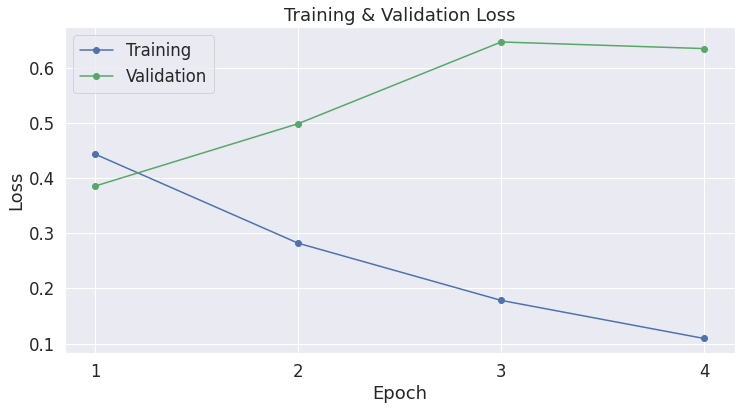

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

As we can see, the best trade-off is training the model for 2 epochs. We will then train our model only for 2 epochs.

In [ ]:
training_stats = train(sentiment_model, criterion, opti, train_loader, val_loader, max_eps=2, gpu=True, print_every=100)

Iteration 100 of epoch 1 complete. Loss : 0.02071591094136238, Accuracy 1.0, Exec_time 38.04s
Iteration 200 of epoch 1 complete. Loss : 0.22351281344890594, Accuracy 0.90625, Exec_time 37.47s
Iteration 300 of epoch 1 complete. Loss : 0.07566087692975998, Accuracy 0.9375, Exec_time 37.54s
Iteration 400 of epoch 1 complete. Loss : 0.0519222691655159, Accuracy 1.0, Exec_time 37.54s
Iteration 500 of epoch 1 complete. Loss : 0.28995150327682495, Accuracy 0.90625, Exec_time 37.63s
Iteration 600 of epoch 1 complete. Loss : 0.20475126802921295, Accuracy 0.9375, Exec_time 37.54s
Iteration 700 of epoch 1 complete. Loss : 0.22369743883609772, Accuracy 0.90625, Exec_time 37.52s
EVALUATION Validation set : mean loss 0.7037773733171299 mean accuracy 0.7814468785966795
Iteration 100 of epoch 2 complete. Loss : 0.006337516941130161, Accuracy 1.0, Exec_time 38.19s
Iteration 200 of epoch 2 complete. Loss : 0.030678117647767067, Accuracy 1.0, Exec_time 37.49s
Iteration 300 of epoch 2 complete. Loss : 0.2

### **Performance on Test Set**
Now, we will test our trained model on the test set. We will compute te MCC score and a classic classififcation report.

In [ ]:
gpu = True

# Evaluation mode
sentiment_model.eval()

# Tracking variables 
predictions , true_labels = [], []

for it, (seq, attn_masks, labels) in enumerate(test_loader): 

  if gpu:
    seq, attn_masks, labels = seq.cuda(), attn_masks.cuda(), labels.cuda()        
  
  #Obtaining the logits from the model
  logits_test = sentiment_model(seq, attn_masks)

  # Move logits and labels to CPU
  logits = logits_test.detach().cpu().numpy()
  label_ids = labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [ ]:
print('Positive samples: %d of %d (%.2f%%)' % (sent_test.sentiment.sum(), len(sent_test.sentiment), (sent_test.sentiment.sum() / len(sent_test.sentiment) * 100.0)))

Positive samples: 6290 of 12402 (50.72%)


The training set is well balanced between positive and negative reviews.

In [ ]:
# Convert predicitions to 0-1 labels
pred_0_1 = []
for pred in predictions:
  pred_0_1.append(np.where(pred > 0, 1, 0))

In [ ]:
import numpy as np
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  #pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  pred_labels_i = pred_0_1[i]
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


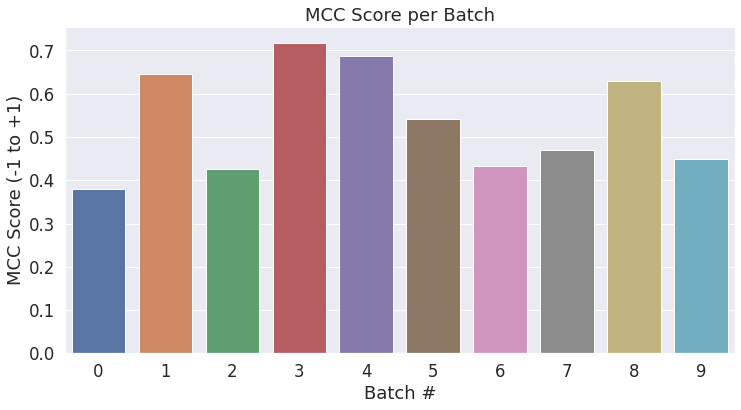

In [ ]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set[:10]))), y=matthews_set[:10], ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

As we can see, the MCC Score is quite different between batches. We can compute this score on all the batches and get the mean MCC score for the entire test set.

In [ ]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(pred_0_1, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
#flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.555


A model with a score of +1 is a perfect model and -1 is a poor model. Here, with a score of 0.555 we can consider that our model has a good score.
Now, we will print the classification report.

Classification Report:
              precision    recall  f1-score   support

           1     0.7456    0.8456    0.7925      6290
           0     0.8157    0.7030    0.7552      6112

    accuracy                         0.7754     12402
   macro avg     0.7806    0.7743    0.7738     12402
weighted avg     0.7801    0.7754    0.7741     12402



[Text(0, 0.5, 'Positive'), Text(0, 1.5, 'Negative')]

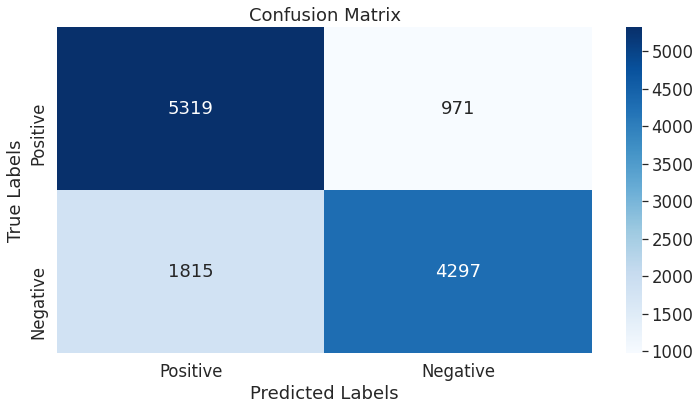

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = flat_predictions
y_true = flat_true_labels

print('Classification Report:')
print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
cm = confusion_matrix(y_true, y_pred, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(['Positive', 'Negative'])
ax.yaxis.set_ticklabels(['Positive', 'Negative'])